In [1]:
!pip install -q pyspellchecker textstat

In [2]:
!pip install lightgbm==3.3.2
import lightgbm as lgb
lgb.__version__

'3.3.2'

In [3]:
import os

class Config:
    AUTHOR = "wanwan7123"

    NAME = "commonlit-exp018-deberta-v3-base"
    MODEL_PATH = "microsoft/deberta-v3-base"
    ROOT = "/notebooks"

    apex=True
    seed = 42
    num_fold = 4
    trn_fold = [0, 1, 2, 3]
    batch_size = 32
    n_epochs = 3
    max_len = 768
    target_list = ["content", "wording"]
    n_targets = len(target_list)
    
    weight_decay = 0.01
    scheduler='cosine'
    betas = (0.9, 0.999)
    encoder_lr = 2e-5
    decoder_lr = 3e-5
    lr_weight_decay = 0.98
    min_lr = 1e-6
    eps = 1e-6
    eval_step = 80
    num_cycles=0.5
    num_warmup_steps_rate=0.1
    clip_grad_norm = 1000
    gradient_accumulation_steps = 1
    
    # GPU Optimize Settings
    gpu_optimize_config= {
        "freezing": False,
        "gradient_checkpoint": True
    }
    
    model_params = {
        "objective": "rmse",
        "metric": "regression",
        "verbosity": -1,
        "learning_rate": 0.01,
        "random_state": seed,
        "feature_fraction": 0.9
    }
    
    lgb_train_params = {
        "num_boost_round": 999999,
    }

In [4]:
import os
import re
import gc
import sys
import json
import time
import shutil
import joblib
import random
import pickle
import requests
import warnings
warnings.filterwarnings('ignore')
from ast import literal_eval
from tqdm.auto import tqdm
from pathlib import Path
from glob import glob

import numpy as np
import pandas as pd
import scipy 
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    StratifiedKFold, 
    KFold, 
    GroupKFold,
    StratifiedGroupKFold
)
from sklearn.metrics import mean_squared_error

from spellchecker import SpellChecker
import textstat

! pip install torch==1.10.1+cu113 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.checkpoint import checkpoint
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F

import lightgbm as lgb

!pip install text-unidecode

Looking in links: https://download.pytorch.org/whl/torch_stable.html


# utils

In [5]:
def setup(cfg):
    cfg.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # pip install
    ! pip install -qq transformers==4.16.2
    ! pip install -qq tokenizers==0.11.6
    ! pip install -qq transformers[sentencepiece]

    # set dirs    
    cfg.INPUT = Path(f"{cfg.ROOT}/input")
    cfg.OUTPUT = Path(f"{cfg.ROOT}/output")
    cfg.EXP = cfg.OUTPUT / cfg.NAME

    cfg.api_path = f"{cfg.ROOT}/kaggle.json"

    cfg.EXP_MODEL = cfg.EXP / "model"
    cfg.EXP_PREDS = cfg.EXP / "preds"

    # make dirs
    for d in [cfg.EXP, cfg.EXP_MODEL, cfg.EXP_PREDS]:
        d.mkdir(exist_ok=True)
        
    # use kaggle api (need kaggle token)
    f = open(cfg.api_path, 'r')
    json_data = json.load(f) 
    os.environ['KAGGLE_USERNAME'] = json_data['username']
    os.environ['KAGGLE_KEY'] = json_data['key']
    
    return cfg

def dataset_create_new(dataset_name, upload_dir):
    dataset_metadata = {}
    dataset_metadata['id'] = f'{os.environ["KAGGLE_USERNAME"]}/{dataset_name}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = dataset_name
    with open(os.path.join(upload_dir, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    api.dataset_create_new(folder=upload_dir, convert_to_csv=False, dir_mode='tar')

In [6]:
# =====================
# Utils
# =====================
# Seed
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def get_commonlit_fold(train):
    id2fold = {
        "814d6b": 0,
        "39c16e": 1,
        "3b9047": 2,
        "ebad26": 3,
    }
    train["fold"] = train["prompt_id"].map(id2fold)
    return train["fold"]

In [7]:
def mcrmse(cfg, preds, df, verbose = True):
    all_score = 0
    for i, column in enumerate(cfg.target_list):
        score = np.sqrt(mean_squared_error(preds[:, i], df[column]))
        if verbose:
            print(f"{column} rmse:", score)
        all_score += score/len(cfg.target_list)
    return all_score

# preprocess

In [8]:
from text_unidecode import unidecode
from typing import Dict, List, Tuple
import codecs

def replace_encoding_with_utf8(error: UnicodeError) -> Tuple[bytes, int]:
    return error.object[error.start : error.end].encode("utf-8"), error.end


def replace_decoding_with_cp1252(error: UnicodeError) -> Tuple[str, int]:
    return error.object[error.start : error.end].decode("cp1252"), error.end

# Register the encoding and decoding error handlers for `utf-8` and `cp1252`.
codecs.register_error("replace_encoding_with_utf8", replace_encoding_with_utf8)
codecs.register_error("replace_decoding_with_cp1252", replace_decoding_with_cp1252)

def resolve_encodings_and_normalize(text: str) -> str:
    """Resolve the encoding problems and normalize the abnormal characters."""
    text = (
        text.encode("raw_unicode_escape")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
        .encode("cp1252", errors="replace_encoding_with_utf8")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
    )
    text = unidecode(text)
    return text

In [9]:
def truncate_text(text):
    words = text.split()
    return ' '.join(words[:1024])

def processing_features(df):
    df['processed_text'] = df['text'].apply(lambda x : resolve_encodings_and_normalize(x))
    df['processed_text'] = df['processed_text'].str.replace('\n', '[BR]')
    df['full_text'] = "[TITLE] " + df["prompt_title"] + " [QUESTION] " + df["prompt_question"] + " [ANSWER] " + df["processed_text"]
    return df

In [10]:
%load_ext Cython

In [11]:
%%cython

import numpy as np
cimport numpy as cnp
cimport cython

@cython.boundscheck(False)  # Arrayの境界チェックを無効化
@cython.wraparound(False)   # 負のインデックスを無効化
def longest_common_substring(str s1, str s2):
    cdef int m, n, i, j, longest
    m, n = len(s1), len(s2)
    
    # Using numpy to initialize the 2D array
    cdef cnp.ndarray[int, ndim=2] dp = np.zeros((m+1, n+1), dtype=np.int32)
    
    longest = 0
    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0 or j == 0:
                dp[i, j] = 0
            elif s1[i - 1] == s2[j - 1]:
                dp[i, j] = dp[i - 1, j - 1] + 1
                longest = max(longest, dp[i, j])
            else:
                dp[i, j] = 0
    return longest

In [12]:
def quotes_count(row):
    text = row['text']
    prompt_text = row['prompt_text']
    quotes_from_text = re.findall(r'"([^"]*)"', text)
    if len(quotes_from_text)>0:
        return [quote in prompt_text for quote in quotes_from_text].count(True)
    else:
        return 0
    
def ngram_co_occurrence(row, n=3):
    text = row["text"]
    prompt_text = row["prompt_text"]

    text_ngram = set(zip(*[text[i:] for i in range(n)]))
    prompt_ngram = set(zip(*[prompt_text[i:] for i in range(n)]))
    return len(text_ngram & prompt_ngram)

def feature_engineering(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = pd.DataFrame()

    # basic
    output_df["n_words"] = input_df["text"].apply(lambda x: len(x.split()))
    output_df["n_unique_words"] = input_df["text"].apply(lambda x: len(set(x.split())))
    output_df["num_sentences"] = input_df["text"].apply(lambda x: len(x.split('.')))
    output_df["is_upper"] = input_df["text"].apply(lambda x: x[0].isupper())
    output_df["mean_num_words"] = input_df["text"].apply(lambda x: np.mean([len(e.split()) for e in x.split('.')]))
    output_df["mean_num_unique_words"] = input_df["text"].apply(lambda x: np.mean([len(set(e.split())) for e in x.split('.')]))
    output_df["num_slash"] = input_df["text"].apply(lambda x: x.count("\n"))
    output_df["paragraph_count"] = input_df["text"].apply(lambda x: x.count("\n\n"))
    output_df["upper_count"] = input_df["text"].apply(lambda x: np.sum([w.isupper() for w in x.split()])/len(x.split()))
    output_df["syntax_count"] = input_df["text"].apply(lambda x: x.count(",") + x.count("-") + x.count(";") + x.count(":"))
    output_df["vocab_strength"] = output_df["n_unique_words"] / output_df["n_words"]
    output_df["new_vocab"] = input_df.apply(lambda x: len(set(x["text"].split()) - set(x["prompt_text"].split())), axis=1)

    # compare
    # overwrap word
    output_df["n_overwrap_unique_word"] = input_df.apply(lambda x: len(set(x["text"].split()) & set(x["prompt_text"].split())), axis=1)
    # longest common substring
    output_df["longest_common_substring"] = input_df.apply(lambda x: longest_common_substring(x["text"], x["prompt_text"]), axis=1)
    # quote
    output_df["quote_count"] = input_df.apply(quotes_count, axis=1)
    # ngram co occurrence
    for n in [3, 4, 5, 6, 7, 8]:
        output_df[f"n_co_occurrence_{n}"] = input_df.apply(ngram_co_occurrence, n=n, axis=1) / output_df["n_words"]
    
    
    # misspell
    spell = SpellChecker()
    output_df["n_misspell"] = input_df["text"].apply(lambda x: len(spell.unknown(x.split())))


    output_df['automated_readability_index'] = input_df["text"].apply(lambda x: textstat.automated_readability_index(x))
    output_df['coleman_liau_index'] = input_df["text"].apply(lambda x: textstat.coleman_liau_index(x))
    output_df['smog_index'] = input_df["text"].apply(textstat.smog_index)
    output_df['dale_chall_readability_score'] = input_df["text"].apply(lambda x: textstat.dale_chall_readability_score(x))
    output_df['linsear_write_formula'] = input_df["text"].apply(lambda x: textstat.linsear_write_formula(x))
    output_df['gunning_fog'] = input_df["text"].apply(textstat.gunning_fog)
    output_df['text_standard_float'] = input_df["text"].apply(textstat.text_standard, float_output=True)
    output_df['spache_readability'] = input_df["text"].apply(textstat.spache_readability)
    output_df['rix'] = input_df["text"].apply(textstat.rix)
    output_df['lix'] = input_df["text"].apply(textstat.lix)


    return output_df

# dataset

In [13]:
class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.text = df['full_text'].to_numpy()
        self.prompt = df['prompt_text'].to_numpy()
        self.labels = df[cfg.target_list].to_numpy()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        input_text = self.prepare_input(self.cfg, self.text[index])
        input_prompt = self.prepare_input(self.cfg, self.prompt[index])
        label = torch.tensor(self.labels[index], dtype=torch.float)
        return input_text, input_prompt, label

    @staticmethod
    def prepare_input(cfg, text):
        inputs = cfg.tokenizer(text,
                               add_special_tokens=True,
                               max_length=cfg.max_len,
                               padding="max_length",
                               truncation=True,
                               return_offsets_mapping=False)
        inputs['input_ids'] = torch.tensor(
            inputs['input_ids'],
            dtype=torch.long
        )
        inputs['attention_mask'] = torch.tensor(
            inputs['attention_mask'],
            dtype=torch.long
        )
        inputs = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
        }
        return inputs

def collate(inputs):
    mask_len = int(inputs["attention_mask"].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs

# model

In [14]:
def freeze(module):
    """
    Freezes module's parameters.
    """
    
    for parameter in module.parameters():
        parameter.requires_grad = False

class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

class CustomModel(nn.Module):
    def __init__(self, cfg): 
        super().__init__()
        self.cfg = cfg
        self.gpu_optimize_config = cfg.gpu_optimize_config
        self.config = AutoConfig.from_pretrained(
            cfg.MODEL_PATH,
            output_hidden_states=True
        )
        self.config.update(
            {
                "output_hidden_states": True,
                "hidden_dropout": 0.,
                "hidden_dropout_prob": 0.,
                "attention_dropout": 0.,
                "attention_probs_dropout_prob": 0.,
            }
        )
        self.backbone = AutoModel.from_pretrained(
            cfg.MODEL_PATH,
            config=self.config
        )

        self.pool = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size*2, cfg.n_targets)
        self._init_weights(self.fc)
        self.ln = nn.LayerNorm(self.config.hidden_size*2)
        self._init_weights(self.ln)

        # Freeze
        if self.gpu_optimize_config['freezing']:
            freeze(self.backbone.encoder.layer[:8])

        # Gradient Checkpointing
        if self.gpu_optimize_config['gradient_checkpoint']:
            self.backbone.gradient_checkpointing_enable()

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def feature(self, inputs):
        outputs = self.backbone(**inputs)
        last_state = outputs[0]
        feature = self.pool(last_state, inputs['attention_mask'])
        return feature

    def forward(self, inputs_text, inputs_prompt, labels):
        # batch, hidden_size
        feature_text = self.feature(inputs_text)
        feature_prompt = self.feature(inputs_prompt)
        # batch, 2
        feature = torch.cat((feature_text, feature_prompt), dim = -1)
        output = self.fc(self.ln(feature))
        if labels is not None:
            loss_fct = nn.SmoothL1Loss(reduction='mean')
            loss = loss_fct(output, labels)
            return loss, output
        else:
            return output

# optimizer, scheduler

In [15]:
def get_optimizer_grouped_parameters(cfg, model):
    model_type = 'backbone'
    no_decay = ["bias", "LayerNorm.weight", "LayerNorm.bias"]
    optimizer_grouped_parameters = [
            {'params': [p for n, p in model.named_parameters() if "backbone" not in n],
             'lr': cfg.decoder_lr, 'weight_decay': 0.0},
    ]
    num_layers = model.config.num_hidden_layers
    layers = [getattr(model, model_type).embeddings] + list(getattr(model, model_type).encoder.layer)
    layers.reverse()
    lr = cfg.encoder_lr
    for layer in layers:
        lr *= cfg.lr_weight_decay
        optimizer_grouped_parameters += [
            {
                "params": [p for n, p in layer.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": cfg.weight_decay,
                "lr": lr,
            },
            {
                "params": [p for n, p in layer.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
                "lr": lr,
            },
        ]
    return optimizer_grouped_parameters

In [16]:
def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=int(num_train_steps*cfg.num_warmup_steps_rate), num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=int(num_train_steps*cfg.num_warmup_steps_rate), num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler

# eval,train

In [17]:
def evaluating(cfg, valid_loader, model, valid_df, fold, best_val_preds, best_val_score):
    val_preds = []
    val_losses = []
    val_nums = []
    model.eval()
    with torch.no_grad():
        with tqdm(valid_loader, total=len(valid_loader)) as pbar:
            for (inputs_text, inputs_prompt, labels) in pbar:
                inputs_text = collate(inputs_text)
                inputs_prompt = collate(inputs_prompt)
                for k, v in inputs_text.items():
                    inputs_text[k] = v.to(cfg.device)
                for k, v in inputs_prompt.items():
                    inputs_prompt[k] = v.to(cfg.device)
                labels = labels.to(cfg.device)
                with autocast():
                    loss, output = model(inputs_text, inputs_prompt, labels)
                
                output = output.detach().cpu().numpy()
                val_preds.append(output)
                val_losses.append(loss.item() * len(labels))
                val_nums.append(len(labels))
                pbar.set_postfix({
                    'val_loss': loss.item()
                })

    val_preds = np.concatenate(val_preds)
    val_loss = sum(val_losses) / sum(val_nums)
    score = mcrmse(cfg, val_preds, valid_df)

    val_log = {
        'val_loss': val_loss,
        'mcrmse': score
    }
    display(val_log)

    if best_val_score > score:
        print('\033[31m'+'save model weight'+'\033[0m')
        best_val_preds = val_preds
        best_val_score = score
        torch.save(
            model.state_dict(), 
            cfg.EXP_MODEL / f"fold{fold}.pth"
        )
    
    return best_val_preds, best_val_score

def training(cfg, train):
    # =====================
    # Training
    # =====================
    set_seed(cfg.seed)
    oof_pred = np.zeros((len(train), 2), dtype=np.float32)
    fold_score = []

    for fold in cfg.trn_fold:
        # dataset, dataloader
        train_df = train.loc[cfg.folds!=fold]
        valid_df = train.loc[cfg.folds==fold]
        train_idx = list(train_df.index)
        valid_idx = list(valid_df.index)

        # Datasetの設定
        train_dataset = TrainDataset(cfg, train_df)
        valid_dataset = TrainDataset(cfg, valid_df)
        train_loader = DataLoader(
            dataset=train_dataset, 
            batch_size=cfg.batch_size,
            shuffle=True,
            pin_memory=True,
            drop_last=True,
        )
        valid_loader = DataLoader(
            dataset=valid_dataset,
            batch_size=cfg.batch_size,
            shuffle=False,
            pin_memory=True,
            drop_last=False,
        )

        # model
        model = CustomModel(cfg)
        model.backbone.resize_token_embeddings(len(cfg.tokenizer))
        torch.save(model.config, cfg.EXP_MODEL / 'config.pth')
        model = model.to(cfg.device)

        # optimizer, scheduler
        optimizer_grouped_parameters = get_optimizer_grouped_parameters(cfg, model)
        optimizer = AdamW(optimizer_grouped_parameters, lr=cfg.encoder_lr, eps=cfg.eps, betas=cfg.betas, weight_decay=cfg.weight_decay)

        num_train_steps = int(len(train_df) / cfg.batch_size * cfg.n_epochs)
        scheduler = get_scheduler(cfg, optimizer, num_train_steps)

        # enable FGM
        # fgm = FGM(model)

        # model-training
        best_val_preds = None
        best_val_score = 9999
        
        for epoch in range(cfg.n_epochs):
            # training
            print(f"# ============ start epoch:{epoch} ============== #")
            train_losses = []
            train_nums = []
            model.train() 
            scaler = GradScaler(enabled=cfg.apex)
            with tqdm(train_loader, total=len(train_loader)) as pbar:
                for step, (inputs_text, inputs_prompt, labels) in enumerate(pbar):
                    inputs_text = collate(inputs_text)
                    inputs_prompt = collate(inputs_prompt)
                    for k, v in inputs_text.items():
                        inputs_text[k] = v.to(cfg.device)
                    for k, v in inputs_prompt.items():
                        inputs_prompt[k] = v.to(cfg.device)
                    labels = labels.to(cfg.device)
                    with autocast(enabled=cfg.apex):
                        loss, output = model(inputs_text, inputs_prompt, labels)

                    pbar.set_postfix({
                        'loss': loss.item(),
                        'lr': scheduler.get_lr()[0]
                    })
                    train_losses.append(loss.item() * len(labels))
                    train_nums.append(len(labels))

                    if cfg.gradient_accumulation_steps > 1:
                        loss = loss / cfg.gradient_accumulation_steps

                    scaler.scale(loss).backward()

                    # FGM attack
                    # fgm.attack()
                    # with autocast(enabled=cfg.apex):
                    #     loss_adv, _ = model(inputs, labels)
                    # scaler.scale(loss_adv).backward()
                    # fgm.restore()
                    
                    if cfg.clip_grad_norm is not None:
                        # scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(
                            model.parameters(),
                            cfg.clip_grad_norm
                        )
                        
                    if (step+1) % cfg.gradient_accumulation_steps == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()
                        scheduler.step()

                    if step % cfg.eval_step == 0 and step != 0:
                        print(f'fold: {fold}, epoch: {epoch}, step: {step}')
                        best_val_preds, best_val_score = evaluating(
                            cfg, valid_loader,
                            model,
                            valid_df,
                            fold,
                            best_val_preds,
                            best_val_score,
                        )
                        model.train()

            train_loss = sum(train_losses)/sum(train_nums)
            train_log = {
                'train_loss':train_loss
            }
            display(train_log)

            # evaluating(epoch)
            print(f'fold: {fold}, epoch: {epoch}, complete')
            best_val_preds, best_val_score = evaluating(
                cfg, valid_loader,
                model,
                valid_df,
                fold,
                best_val_preds,
                best_val_score,
            )

        oof_pred[valid_idx] = best_val_preds.astype(np.float32)
        np.save(cfg.EXP_PREDS / f'oof_pred_fold{fold}.npy', best_val_preds)
        fold_score.append(best_val_score)
        del model; gc.collect()

    np.save(cfg.EXP_PREDS / 'oof_pred.npy', oof_pred)

    # =====================
    # scoring
    # =====================
    score = mcrmse(cfg, oof_pred, train)
    print('fold score：', fold_score)
    print('CV:', round(score, 4))
    return score

# main

In [18]:
# setup
cfg = setup(Config)

import transformers
from transformers import AutoConfig, AutoModel, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
import tokenizers
import sentencepiece
%env TOKENIZERS_PARALLELISM=true
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")

# main
train_df = pd.read_csv(cfg.INPUT / "summaries_train.csv")
feedback3_pred = pd.read_csv(cfg.INPUT / "pred_feedback3value.csv")
prompts_train_df = pd.read_csv(cfg.INPUT / "prompts_train.csv")


train_df = train_df.merge(prompts_train_df, on="prompt_id")
train_df = processing_features(train_df)
train_feat_df = feature_engineering(train_df)

cfg.tokenizer = AutoTokenizer.from_pretrained(cfg.MODEL_PATH)
cfg.tokenizer.add_tokens(["[BR]", "[TITLE]", "[QUESTION]", "[ANSWER]"], special_tokens=True)
cfg.tokenizer.save_pretrained(cfg.EXP / 'tokenizer')
cfg.folds = get_commonlit_fold(train_df)
cfg.folds.to_csv(cfg.EXP_PREDS / 'folds.csv')

env: TOKENIZERS_PARALLELISM=true
tokenizers.__version__: 0.11.6
transformers.__version__: 4.16.2


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [19]:
train_df.loc[0, "full_text"]

'[TITLE] The Third Wave [QUESTION] Summarize how the Third Wave developed over such a short period of time and why the experiment was ended. [ANSWER] The third wave was an experimentto see how people reacted to a new one leader government. It gained popularity as people wanted to try new things. The students follow anything that is said and start turning on eachother to gain higher power. They had to stop the experement as too many people got to radical with it blindly following there leader'

In [20]:
score = training(cfg, train_df)

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# ============ start epoch:0 ============== #


  0%|          | 0/189 [00:00<?, ?it/s]

fold: 0, epoch: 0, step: 80


  0%|          | 0/35 [00:00<?, ?it/s]

content rmse: 0.5867341003930843
wording rmse: 0.8128494848422892


{'val_loss': 0.22672394474635638, 'mcrmse': 0.6997917926176868}

save model weight
fold: 0, epoch: 0, step: 160


  0%|          | 0/35 [00:00<?, ?it/s]

content rmse: 0.5490175714993605
wording rmse: 0.9302668030021567


{'val_loss': 0.2619085612884999, 'mcrmse': 0.7396421872507586}

{'train_loss': 0.2286320005853971}

fold: 0, epoch: 0, complete


  0%|          | 0/35 [00:00<?, ?it/s]

content rmse: 0.5512803944362259
wording rmse: 0.7274410414439162


{'val_loss': 0.19097028671344193, 'mcrmse': 0.6393607179400711}

save model weight
# ============ start epoch:1 ============== #


  0%|          | 0/189 [00:00<?, ?it/s]

fold: 0, epoch: 1, step: 80


  0%|          | 0/35 [00:00<?, ?it/s]

content rmse: 0.5467943994129454
wording rmse: 0.7457965252844768


{'val_loss': 0.1947060596478169, 'mcrmse': 0.6462954623487112}

fold: 0, epoch: 1, step: 160


  0%|          | 0/35 [00:00<?, ?it/s]

content rmse: 0.5184366833874648
wording rmse: 0.7784873111562438


{'val_loss': 0.20044369948310195, 'mcrmse': 0.6484619972718544}

{'train_loss': 0.11338939935599686}

fold: 0, epoch: 1, complete


  0%|          | 0/35 [00:00<?, ?it/s]

content rmse: 0.517653682957302
wording rmse: 0.7465017268008045


{'val_loss': 0.188887348660316, 'mcrmse': 0.6320777048790532}

save model weight
# ============ start epoch:2 ============== #


  0%|          | 0/189 [00:00<?, ?it/s]

fold: 0, epoch: 2, step: 80


  0%|          | 0/35 [00:00<?, ?it/s]

content rmse: 0.5324962731056768
wording rmse: 0.7164213912167031


{'val_loss': 0.18195143872947986, 'mcrmse': 0.6244588321611899}

save model weight


KeyboardInterrupt: 

In [ ]:
oof = np.load(cfg.EXP_PREDS / "oof_pred.npy")

In [ ]:
mcrmse(cfg, oof, train_df)

In [ ]:
feedback3_pred = feedback3_pred.drop('prompt_id', axis = 1)
feedback3_pred.head()

In [ ]:
train_df = train_df.merge(feedback3_pred, on="student_id")
train_df.head()

# LightGBM

In [ ]:
bert_cols = [f"pred_{i}" for i in cfg.target_list]
train_feat_df[bert_cols] = oof

feedback3_cols = ["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]
train_feat_df[feedback3_cols] = train_df[["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]]

display(train_feat_df.head(1))

In [ ]:
oof_pred_lgbm = np.zeros((len(train_feat_df), 2), dtype=np.float32)
models = []

def training_lgbm(cfg, train_feat_df, target_df):
    for fold in range(cfg.num_fold):
        print("="*30, f"Fold {fold}", "="*30)
        X_train = train_feat_df.loc[cfg.folds!=fold]
        X_valid = train_feat_df.loc[cfg.folds==fold]
        train_idx = list(X_train.index)
        valid_idx = list(X_valid.index)
        
        print(f"Train: {X_train.shape}, Valid: {X_valid.shape}")
        for i, target in enumerate(cfg.target_list):
            y_train = target_df.iloc[train_idx][target].reset_index(drop=True)
            y_valid = target_df.iloc[valid_idx][target].reset_index(drop=True)

            train_dataset = lgb.Dataset(X_train, y_train)
            valid_dataset = lgb.Dataset(X_valid, y_valid)

            model = lgb.train(
                params=cfg.model_params,
                train_set=train_dataset,
                valid_sets=[train_dataset, valid_dataset],
                callbacks=[
                    lgb.early_stopping(100),
                    lgb.log_evaluation(1000)
                    ],
                **cfg.lgb_train_params
            )
            models.append(model)
            pickle.dump(model, open(cfg.EXP_MODEL /  f"lgbm_fold{fold}_{target}.pkl", "wb"))

            oof_pred_lgbm[valid_idx, i] = model.predict(X_valid)

            score = np.sqrt(mean_squared_error(y_valid, oof_pred_lgbm[valid_idx, i]))

            print(f"Fold {fold} Target {target} RMSE: {score:.4f}")

    pickle.dump(oof_pred_lgbm, open(cfg.EXP_PREDS /  f"oof_lgbm.pkl", "wb"))
    score = mcrmse(cfg, oof_pred_lgbm, target_df, verbose = True)
    print(f"Overall RMSE: {score:.5f}")

In [ ]:
training_lgbm(cfg, train_feat_df, train_df[cfg.target_list])

<AxesSubplot: xlabel='importance', ylabel='feature'>

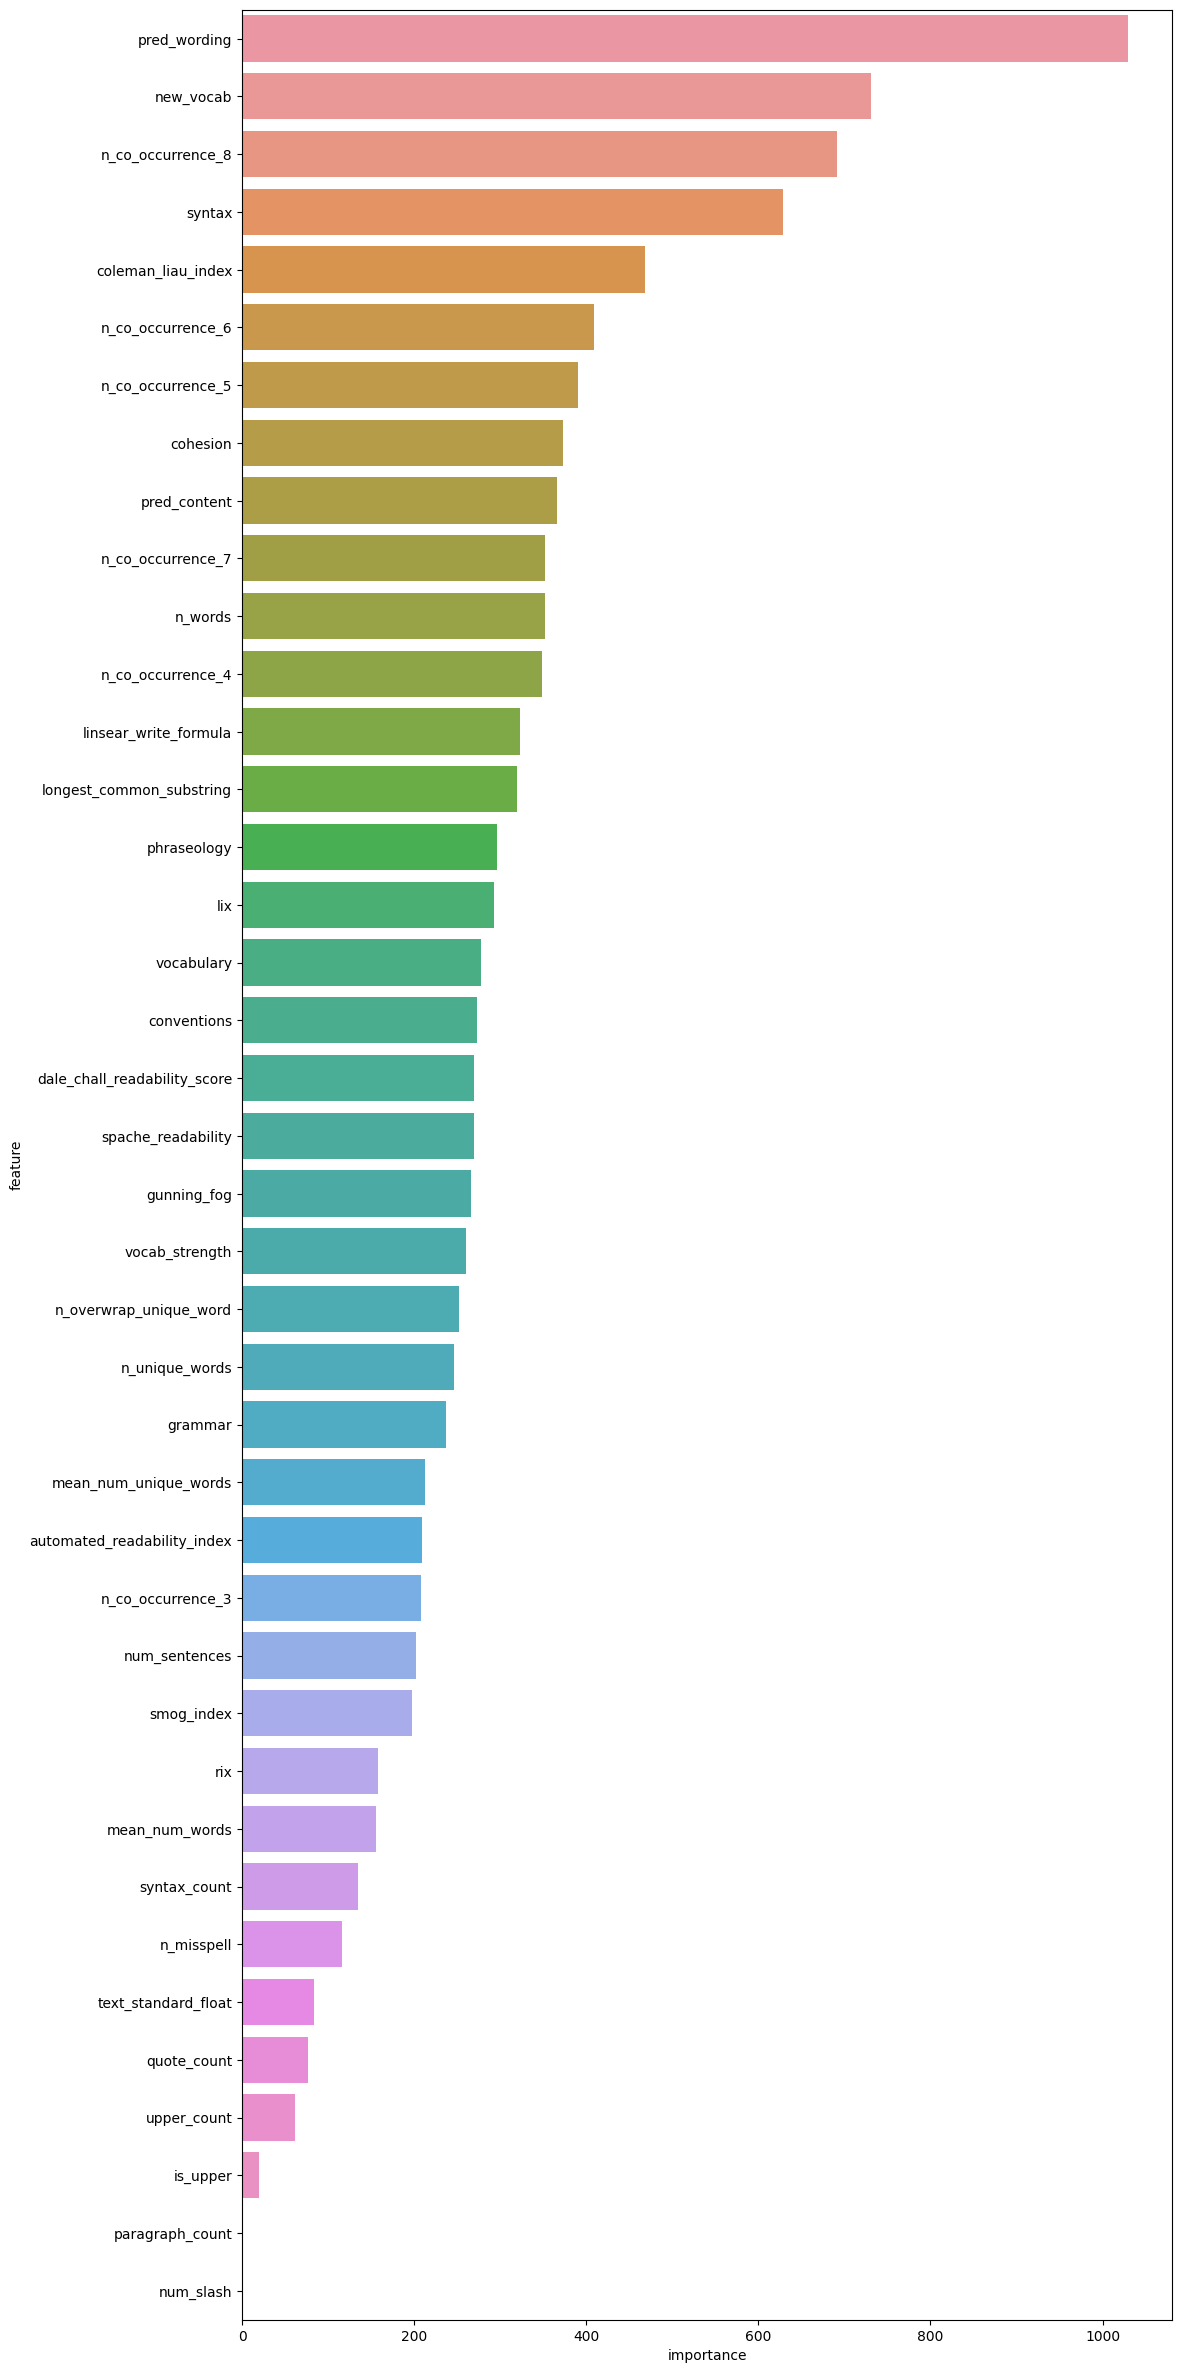

In [28]:
importance_df = pd.DataFrame()
for fold in range(cfg.num_fold):
    model = pickle.load(open(cfg.EXP_MODEL / f"lgbm_fold{fold}_wording.pkl", "rb"))
    _df = pd.DataFrame()
    _df["feature"] = model.feature_name()
    _df["importance"] = model.feature_importance()
    _df["fold"] = fold
    importance_df = pd.concat([importance_df, _df], axis=0)

importance_df.groupby("feature").agg({"importance": ["mean", "std"]}).sort_values(("importance", "mean"), ascending=False)

fig, ax = plt.subplots(figsize=(12, 30))
sns.barplot(x="importance", y="feature", data=importance_df.groupby("feature").agg({"importance": "mean"}).reset_index().sort_values("importance", ascending=False), ax=ax)

In [29]:
!pip install -qq kaggle
from pathlib import PosixPath
from kaggle.api.kaggle_api_extended import KaggleApi
dataset_create_new(dataset_name=Config.NAME, upload_dir=Config.EXP)

Starting upload for file tokenizer.tar


100%|██████████| 2.36M/2.36M [00:00<00:00, 5.57MB/s]


Upload successful: tokenizer.tar (2MB)
Starting upload for file model.tar


100%|██████████| 2.75G/2.75G [00:29<00:00, 99.4MB/s]


Upload successful: model.tar (3GB)
Starting upload for file preds.tar


100%|██████████| 210k/210k [00:00<00:00, 469kB/s]


Upload successful: preds.tar (210KB)


In [30]:
import lightgbm as lgb
lgb.__version__

'3.3.2'

In [45]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import TruncatedSVD

class TextVectorizer:
    def __init__(self, model_name='all-mpnet-base-v2', target_dim=64):
        self.encoder = SentenceTransformer(model_name)
        self.svd = TruncatedSVD(n_components=target_dim, random_state=42)
        self.target_dim = target_dim
        self.is_fit = False

    def transform(self, texts):
        embeddings = self.encoder.encode(texts, show_progress_bar=True)
        # if not self.is_fit:
        #     self.svd.fit(embeddings)
        #     self.is_fit = True
        # return self.svd.transform(embeddings)
        return embeddings

def get_64_dim_vector(texts):
    vectorizer = TextVectorizer(target_dim=64, )
    return vectorizer.transform(texts)

# 使用例
texts = [
    "これはテスト文章です。",
    "Sentence Transformersは非常に便利です。",
    "次元削減はデータの圧縮や可視化に役立ちます。"
]

vectors_text = get_64_dim_vector(train_df["processed_text"])

Batches:   0%|          | 0/224 [00:00<?, ?it/s]

In [46]:
vectors_text.shape

(7165, 768)

In [47]:
vectors_prompt = get_64_dim_vector(train_df["prompt_text"])

Batches:   0%|          | 0/224 [00:00<?, ?it/s]

In [48]:
import numpy as np

def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [49]:
cos_sims = []
for i in range(7165):
    cos_sims.append(cos_sim(vectors_text[i], vectors_prompt[i]))

In [50]:
train_df["cos_sim"] = cos_sims

<AxesSubplot: xlabel='cos_sim', ylabel='content'>

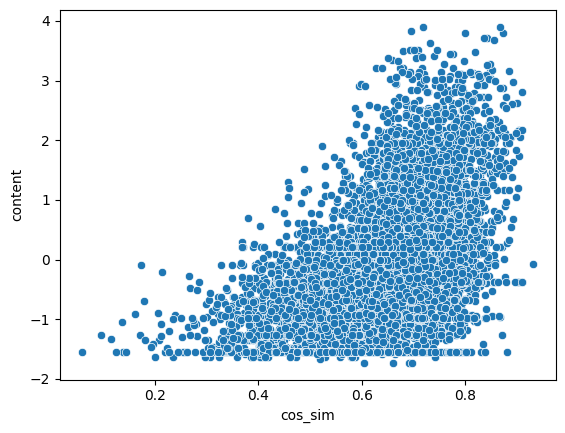

In [51]:
sns.scatterplot(x = train_df["cos_sim"], y =train_df["content"])

In [52]:
train_df.corr()

,content,wording,fold,cos_sim
content,1.000000,0.751380,-0.044291,0.467056
wording,0.751380,1.000000,-0.206594,0.225361
fold,-0.044291,-0.206594,1.000000,0.178308
cos_sim,0.467056,0.225361,0.178308,1.000000
